In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import random
import seaborn as sns
from torch import nn


In [3]:
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
rndm_state = 42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
traindata = torch.load('/content/drive/MyDrive/MLCS/mlcb_data/bigram/bigram_train7500.pt')
validate = torch.load('/content/drive/MyDrive/MLCS/mlcb_data/bigram/bigram_val7500.pt')
test = torch.load('/content/drive/MyDrive/MLCS/mlcb_data/bigram/bigram_test7500.pt')
print(test[0][0])

cuda
tensor([10164.,  1212.,   297.,  ...,     0.,     0.,     0.])


In [17]:
batch_size = 100
num_epochs = 50
num_epochs = int(num_epochs)
reg=0.001

In [18]:

train_loader_nn = torch.utils.data.DataLoader(dataset=traindata,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader_nn = torch.utils.data.DataLoader(dataset=validate,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader_nn = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          shuffle=False)


In [19]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim[0]) 
        # Non-linearity
        self.sigmoid1 = nn.Sigmoid()
        self.drp1 = nn.Dropout(0.1)
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1]) 
        self.sigmoid2 = nn.Sigmoid() 
        self.drp2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(hidden_dim[1], hidden_dim[1]) 
        self.sigmoid3 = nn.Sigmoid() 
        self.drp3 = nn.Dropout(0.1)


        self.fc4 = nn.Linear(hidden_dim[1], output_dim)  

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid1(out)
        out = self.drp1(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        out = self.sigmoid2(out)
        out = self.drp2(out)
        # Linear function (readout)  # LINEAR
        out = self.fc3(out)
        out = self.sigmoid3(out)
        out = self.drp3(out)


        out = self.fc4(out)
        return out

In [20]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

In [21]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 7501
hidden_dim = [1000,800]
output_dim = 10

model = Net(input_dim, hidden_dim, output_dim)
model.apply(weights_init)
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 2e-3
learning_rate_decay = 0.95
optimizer =torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
loss_ar = []
lr = learning_rate
total_train = 0
correct_train = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader_nn):
        # images = images.to(device)
        # labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        labels = labels.type(torch.LongTensor)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #####
        
        if (i+1) % 92 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted_train = torch.max(outputs.data, 1)
            loss_ar.append(loss.item())
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()      
    # train_accu.append(100 * correct_train / total_train)
    correct_train = 0
    total_train = 0
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader_nn:
            # images = images.to(device)
            # labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #############
        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        

Epoch [1/50], Loss: 0.8510
Validataion accuracy is: 69.70770593445528 %
Epoch [2/50], Loss: 0.7773
Validataion accuracy is: 76.10717449069973 %
Epoch [3/50], Loss: 0.7021
Validataion accuracy is: 78.18866253321524 %
Epoch [4/50], Loss: 0.5220
Validataion accuracy is: 75.8414526129318 %
Epoch [5/50], Loss: 0.4736
Validataion accuracy is: 78.38795394154118 %
Epoch [6/50], Loss: 0.5744
Validataion accuracy is: 79.00797165633304 %
Epoch [7/50], Loss: 0.7273
Validataion accuracy is: 79.84942426926483 %
Epoch [8/50], Loss: 0.5988
Validataion accuracy is: 74.5792736935341 %
Epoch [9/50], Loss: 0.8058
Validataion accuracy is: 77.59078830823738 %
Epoch [10/50], Loss: 0.6078
Validataion accuracy is: 79.82728077945085 %
Epoch [11/50], Loss: 0.7030
Validataion accuracy is: 77.32506643046945 %
Epoch [12/50], Loss: 0.6703
Validataion accuracy is: 79.42869796279894 %
Epoch [13/50], Loss: 0.5908
Validataion accuracy is: 80.20372010628876 %
Epoch [14/50], Loss: 0.4986
Validataion accuracy is: 80.558015

**bigram_train7500**

Epoch [1/50], Loss: 0.6688
Validataion accuracy is: 74.42426926483614 %
Epoch [2/50], Loss: 0.6364
Validataion accuracy is: 78.7643932683791 %
Epoch [3/50], Loss: 0.6522
Validataion accuracy is: 78.18866253321524 %
Epoch [4/50], Loss: 0.7180
Validataion accuracy is: 79.42869796279894 %
Epoch [5/50], Loss: 0.6022
Validataion accuracy is: 79.22940655447299 %
Epoch [6/50], Loss: 0.5198
Validataion accuracy is: 79.51727192205492 %
Epoch [7/50], Loss: 0.4719
Validataion accuracy is: 80.4251550044287 %
Epoch [8/50], Loss: 0.4454
Validataion accuracy is: 79.62798937112488 %
Epoch [9/50], Loss: 0.3705
Validataion accuracy is: 78.41009743135518 %
Epoch [10/50], Loss: 0.5885
Validataion accuracy is: 78.7422497785651 %
Epoch [11/50], Loss: 0.4073
Validataion accuracy is: 78.8086802480071 %
Epoch [12/50], Loss: 0.3821
Validataion accuracy is: 79.87156775907883 %
Epoch [13/50], Loss: 0.5717
Validataion accuracy is: 78.47652790079717 %
Epoch [14/50], Loss: 0.5506
Validataion accuracy is: 79.42869796279894 %
Epoch [15/50], Loss: 0.5596
Validataion accuracy is: 80.0044286979628 %
Epoch [16/50], Loss: 0.4324
Validataion accuracy is: 81.08945969884854 %
Epoch [17/50], Loss: 0.7225
Validataion accuracy is: 79.00797165633304 %
Epoch [18/50], Loss: 0.4605
Validataion accuracy is: 80.15943312666076 %
Epoch [19/50], Loss: 0.4401
Validataion accuracy is: 80.97874224977856 %
Epoch [20/50], Loss: 0.4416
Validataion accuracy is: 80.73516386182462 %
Epoch [21/50], Loss: 0.5306
Validataion accuracy is: 80.27015057573074 %
Epoch [22/50], Loss: 0.4214
Validataion accuracy is: 81.06731620903454 %
Epoch [23/50], Loss: 0.4480
Validataion accuracy is: 80.93445527015058 %
Epoch [24/50], Loss: 0.5330
Validataion accuracy is: 81.24446412754651 %
Epoch [25/50], Loss: 0.5018
Validataion accuracy is: 81.00088573959256 %
Epoch [26/50], Loss: 0.3398
Validataion accuracy is: 81.31089459698849 %
Epoch [27/50], Loss: 0.4265
Validataion accuracy is: 81.28875110717449 %
Epoch [28/50], Loss: 0.4777
Validataion accuracy is: 80.80159433126661 %
Epoch [29/50], Loss: 0.5783
Validataion accuracy is: 79.78299379982285 %
Epoch [30/50], Loss: 0.4275
Validataion accuracy is: 81.70947741364039 %
Epoch [31/50], Loss: 0.4662
Validataion accuracy is: 81.6209034543844 %
Epoch [32/50], Loss: 0.4101
Validataion accuracy is: 80.89016829052258 %
Epoch [33/50], Loss: 0.5293
Validataion accuracy is: 81.57661647475642 %
Epoch [34/50], Loss: 0.3141
Validataion accuracy is: 81.77590788308237 %
Epoch [35/50], Loss: 0.4622
Validataion accuracy is: 81.77590788308237 %
Epoch [36/50], Loss: 0.4994
Validataion accuracy is: 80.95659875996456 %
Epoch [37/50], Loss: 0.4514
Validataion accuracy is: 81.57661647475642 %
Epoch [38/50], Loss: 0.4841
Validataion accuracy is: 81.44375553587246 %
Epoch [39/50], Loss: 0.5099
Validataion accuracy is: 81.73162090345438 %
Epoch [40/50], Loss: 0.2883
Validataion accuracy is: 81.77590788308237 %
Epoch [41/50], Loss: 0.4645
Validataion accuracy is: 81.48804251550044 %
Epoch [42/50], Loss: 0.4095
Validataion accuracy is: 81.42161204605846 %
Epoch [43/50], Loss: 0.3892
Validataion accuracy is: 81.59875996457042 %
Epoch [44/50], Loss: 0.3665
Validataion accuracy is: 81.82019486271037 %
Epoch [45/50], Loss: 0.4237
Validataion accuracy is: 81.70947741364039 %
Epoch [46/50], Loss: 0.6079
Validataion accuracy is: 81.46589902568645 %
Epoch [47/50], Loss: 0.4779
Validataion accuracy is: 81.11160318866253 %
Epoch [48/50], Loss: 0.3820
Validataion accuracy is: 81.53232949512844 %
Epoch [49/50], Loss: 0.5560
Validataion accuracy is: 81.59875996457042 %
Epoch [50/50], Loss: 0.4971
Validataion accuracy is: 81.35518157661647 %


Epoch [1/50], Loss: 0.9497
Validataion accuracy is: 59.89813994685562 %
Epoch [2/50], Loss: 0.9597
Validataion accuracy is: 67.27192205491585 %
Epoch [3/50], Loss: 0.9778
Validataion accuracy is: 70.10628875110717 %
Epoch [4/50], Loss: 0.8171
Validataion accuracy is: 70.50487156775908 %
Epoch [5/50], Loss: 0.8459
Validataion accuracy is: 70.96988485385296 %
Epoch [6/50], Loss: 0.8557
Validataion accuracy is: 71.50132860938884 %
Epoch [7/50], Loss: 0.6675
Validataion accuracy is: 71.72276350752878 %
Epoch [8/50], Loss: 0.8069
Validataion accuracy is: 70.61558901682905 %
Epoch [9/50], Loss: 1.0148
Validataion accuracy is: 70.90345438441098 %
Epoch [10/50], Loss: 0.4866
Validataion accuracy is: 69.53055801594331 %
Epoch [11/50], Loss: 0.7937
Validataion accuracy is: 72.14348981399469 %
Epoch [12/50], Loss: 0.6796
Validataion accuracy is: 72.63064658990257 %
Epoch [13/50], Loss: 0.7484
Validataion accuracy is: 72.40921169176262 %
Epoch [14/50], Loss: 0.6672
Validataion accuracy is: 73.7378210806023 %
Epoch [15/50], Loss: 0.5840
Validataion accuracy is: 72.29849424269266 %
Epoch [16/50], Loss: 1.0681
Validataion accuracy is: 73.02922940655448 %
Epoch [17/50], Loss: 0.7418
Validataion accuracy is: 72.36492471213464 %
Epoch [18/50], Loss: 0.7297
Validataion accuracy is: 72.5199291408326 %
Epoch [19/50], Loss: 0.7504
Validataion accuracy is: 73.93711248892825 %
Epoch [20/50], Loss: 0.6508
Validataion accuracy is: 74.00354295837023 %
Epoch [21/50], Loss: 0.5703
Validataion accuracy is: 73.91496899911427 %
Epoch [22/50], Loss: 0.8628
Validataion accuracy is: 72.16563330380868 %
Epoch [23/50], Loss: 0.8199
Validataion accuracy is: 74.31355181576616 %
Epoch [24/50], Loss: 0.7897
Validataion accuracy is: 73.44995571302037 %
Epoch [25/50], Loss: 0.6459
Validataion accuracy is: 74.13640389725421 %
Epoch [26/50], Loss: 0.7564
Validataion accuracy is: 74.77856510186005 %
Epoch [27/50], Loss: 0.6729
Validataion accuracy is: 74.37998228520814 %
Epoch [28/50], Loss: 0.5746
Validataion accuracy is: 72.07705934455271 %
Epoch [29/50], Loss: 0.6035
Validataion accuracy is: 74.22497785651018 %
Epoch [30/50], Loss: 0.6545
Validataion accuracy is: 74.64570416297609 %
Epoch [31/50], Loss: 0.7362
Validataion accuracy is: 72.54207263064659 %
Epoch [32/50], Loss: 0.7752
Validataion accuracy is: 75.08857395925598 %
Epoch [33/50], Loss: 0.6363
Validataion accuracy is: 73.38352524357839 %
Epoch [34/50], Loss: 0.8265
Validataion accuracy is: 74.51284322409212 %
Epoch [35/50], Loss: 0.7035
Validataion accuracy is: 73.36138175376439 %
Epoch [36/50], Loss: 0.5270
Validataion accuracy is: 75.11071744906998 %
Epoch [37/50], Loss: 0.6222
Validataion accuracy is: 74.91142604074402 %
Epoch [38/50], Loss: 0.7251
Validataion accuracy is: 74.75642161204605 %
Epoch [39/50], Loss: 0.5823
Validataion accuracy is: 75.39858281665191 %
Epoch [40/50], Loss: 1.0262
Validataion accuracy is: 74.80070859167405 %
Epoch [41/50], Loss: 0.5742
Validataion accuracy is: 75.15500442869796 %
Epoch [42/50], Loss: 0.6343
Validataion accuracy is: 75.17714791851196 %
Epoch [43/50], Loss: 0.6050
Validataion accuracy is: 75.22143489813995 %
Epoch [44/50], Loss: 0.6550
Validataion accuracy is: 75.13286093888397 %
Epoch [45/50], Loss: 0.5281
Validataion accuracy is: 73.62710363153234 %
Epoch [46/50], Loss: 0.6402
Validataion accuracy is: 75.64216120460584 %
Epoch [47/50], Loss: 0.5252
Validataion accuracy is: 74.80070859167405 %
Epoch [48/50], Loss: 0.6554
Validataion accuracy is: 75.53144375553588 %
Epoch [49/50], Loss: 0.7233
Validataion accuracy is: 75.22143489813995 %
Epoch [50/50], Loss: 0.7553
Validataion accuracy is: 75.04428697962798 %

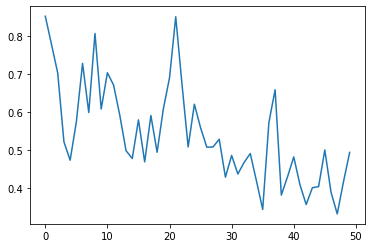

In [24]:
plt.plot(range(num_epochs),loss_ar)

In [25]:
def test(test_loader_nn,model):

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_nn:

      # images = images.to(device)

      # labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

# if total == 1000:
# break



  print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))
  return test_loader_nn,predicted

In [26]:
test(test_loader_nn,model)

Accuracy of the network on the 10000 test images: 82.62 %


(<torch.utils.data.dataloader.DataLoader at 0x7fed87608f90>,
 tensor([4, 8, 9, 4, 7, 0, 2, 7, 4, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 4, 3, 4, 3, 8, 7, 7, 2, 7, 1, 7, 3, 4, 7, 3, 6, 8, 7,
         9, 4, 7, 7, 3, 7, 3, 9, 4, 7, 7, 8, 4, 0, 6, 4, 4, 7, 7, 4, 2, 2, 4, 7,
         7, 4, 7, 3, 4, 7, 9, 4, 7, 7, 7, 4, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))

unigram 10
Accuracy of the network on the 10000 test images: 75.51 %
(<torch.utils.data.dataloader.DataLoader at 0x7ff4cf69a050>,
 tensor([7, 4, 9, 7, 7, 0, 2, 4, 7, 2, 3, 1, 3, 2, 7, 0, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 4, 3, 7, 3, 8, 7, 7, 2, 7, 1, 7, 3, 4, 7, 3, 6, 8, 7,
         9, 7, 7, 7, 3, 7, 3, 4, 4, 9, 7, 8, 7, 4, 6, 4, 7, 7, 7, 7, 2, 2, 4, 7,
         7, 7, 7, 3, 0, 7, 9, 7, 7, 7, 7, 7, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))

bigram 10
Accuracy of the network on the 10000 test images: 73.67 %
(<torch.utils.data.dataloader.DataLoader at 0x7ff4ce8596d0>,
 tensor([7, 4, 9, 9, 7, 4, 2, 7, 7, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 8, 3, 7, 3, 8, 7, 7, 2, 7, 1, 4, 3, 4, 7, 3, 6, 8, 7,
         9, 7, 7, 7, 3, 7, 3, 4, 4, 7, 7, 8, 7, 7, 6, 4, 7, 7, 7, 7, 2, 2, 4, 7,
         7, 7, 7, 3, 4, 7, 9, 7, 7, 7, 7, 7, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 7, 2, 8]))

bigram 1000
Accuracy of the network on the 10000 test images: 82.02 %
(<torch.utils.data.dataloader.DataLoader at 0x7f9a52490690>,
 tensor([4, 4, 9, 4, 7, 4, 2, 0, 4, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 4, 3, 4, 3, 8, 7, 7, 2, 7, 1, 4, 3, 4, 7, 3, 6, 8, 7,
         9, 4, 7, 7, 3, 7, 3, 0, 4, 7, 7, 8, 4, 0, 6, 4, 4, 7, 7, 7, 2, 2, 4, 7,
         7, 4, 7, 3, 4, 7, 9, 4, 7, 7, 7, 4, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))

bigram 5000
Accuracy of the network on the 10000 test images: 82.37 %
(<torch.utils.data.dataloader.DataLoader at 0x7f9a51e86f90>,
 tensor([4, 8, 9, 4, 7, 0, 2, 7, 4, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 0, 3, 4, 3, 8, 7, 7, 2, 7, 1, 7, 3, 4, 7, 3, 6, 8, 7,
         9, 4, 7, 7, 3, 7, 3, 0, 4, 7, 7, 8, 4, 0, 6, 4, 4, 7, 7, 4, 2, 2, 4, 7,
         7, 4, 7, 3, 4, 7, 9, 4, 7, 7, 7, 7, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))         
bigrams 7500
Accuracy of the network on the 10000 test images: 82.59 %
(<torch.utils.data.dataloader.DataLoader at 0x7f9a51e1c390>,
 tensor([4, 8, 9, 4, 7, 4, 2, 7, 4, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 0, 3, 4, 3, 8, 7, 7, 2, 7, 1, 7, 3, 4, 7, 3, 6, 8, 7,
         9, 4, 7, 7, 3, 7, 3, 4, 4, 4, 7, 8, 4, 0, 6, 4, 4, 7, 7, 4, 2, 2, 4, 7,
         7, 4, 7, 3, 4, 7, 9, 4, 7, 7, 7, 4, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))

bigrams 7500 - 4 layers NN with dropout
Accuracy of the network on the 10000 test images: 82.62 %
(<torch.utils.data.dataloader.DataLoader at 0x7fed87608f90>,
 tensor([4, 8, 9, 4, 7, 0, 2, 7, 4, 2, 3, 1, 3, 2, 7, 4, 3, 7, 9, 3, 4, 7, 7, 7,
         7, 2, 1, 3, 9, 3, 4, 3, 4, 3, 8, 7, 7, 2, 7, 1, 7, 3, 4, 7, 3, 6, 8, 7,
         9, 4, 7, 7, 3, 7, 3, 9, 4, 7, 7, 8, 4, 0, 6, 4, 4, 7, 7, 4, 2, 2, 4, 7,
         7, 4, 7, 3, 4, 7, 9, 4, 7, 7, 7, 4, 9, 7, 7, 2, 7, 4, 2, 7, 3, 2, 7, 3,
         3, 4, 2, 8]))